# Introduction to Python for quantitative finance.


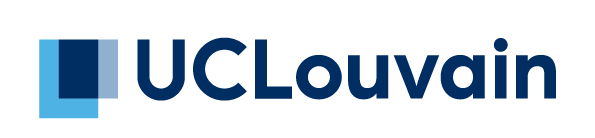



*Author* : Ubeydullah Ozcan (ozcanubey@outlook.com)

## Course 4 - Efficient frontier and optimal portfolio under risk budget

### Efficient frontier

***Defintion*** : In modern portfolio theory, the efficient frontier (or portfolio frontier) is an investment portfolio which occupies the "efficient" parts of the risk–return spectrum. Formally, it is the set of portfolios which satisfy the condition that no other portfolio exists with a higher expected return but with the same standard deviation of return (i.e., the risk)

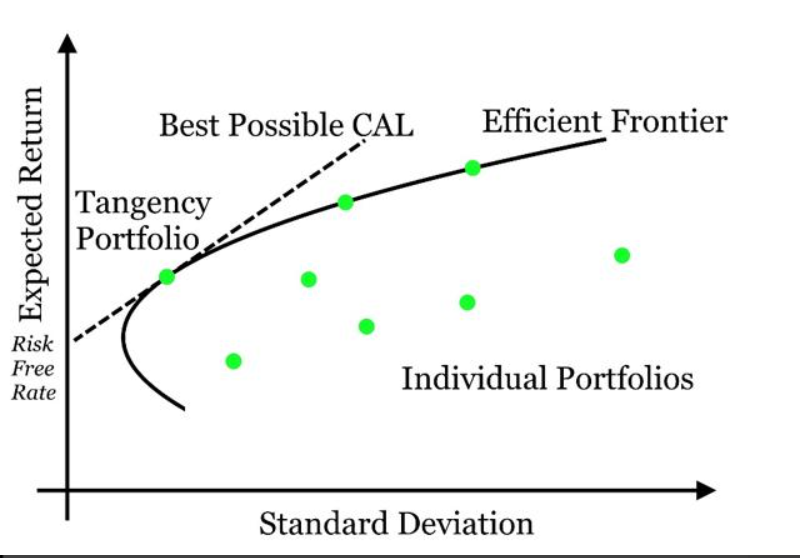




The graph below is the representation in term of risk-return of portfolios and for individual portfolios. The idea behind the efficient frontier is that it is impossible to reach this frontier by investing in indivual assets. 

Now, let's see how this frontier is build.

First, we need to recall the formula that helps us to calculate optimal portfolio and calculate the expected return and variance of optimal portfolio.

### Formulas

#### In absence of risk-free asset
$$w(\gamma) = \frac{1}{\gamma} \Sigma^{-1} (\mu - \lambda(\gamma)e)$$
where $$\lambda(\gamma) = \frac{e^T\Sigma^{-1}\mu - \gamma}{e^T \Sigma^{-1}e}$$

Portfolio's variance : $\sigma_{P}^2 = w^T \Sigma  w$ where $\Sigma$ is the covariance matrix

Portfolio's expected return : $\mu_p = w^T \mu$

#### In presence of a risk-free asset
$$w(\gamma) = \frac{1}{\gamma} \Sigma^{-1} (\mu - re)$$

Portfolio's variance : $\sigma_{P}^2 = w^T \Sigma  w$ where $\Sigma$ is the covariance matrix

Portfolio's expected return : $\mu_p = w^T \mu + (1- w^T e)r$

The efficient frontier is build by calculate a set of $\mu_p$ and $\sigma_p$ for a set of $\gamma$. Let's see how does it work in Python.

### Code

####  1- Needed packages

In [1]:
from os import name
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as web
import pandas as pd
import numpy as np
import datetime
import math

#### 2 - Inputs

In [2]:
start = datetime.datetime(2018,1,1)
end = datetime.datetime(2020,12,31)
stocks = ['AAPL', 'NVDA', "AMZN"]

#### 3 - Functions

##### 3.1 -  Import weekly stocks price and calculate returns

In [3]:
def Import_stocks(name, start, end):

    n = len(name)
    ptf = pd.DataFrame()
    for i in np.arange(n):
        #tmp = pd.DataFrame(web.DataReader(name[i],'yahoo', start, end)["Close"])
        tmp = web.get_data_yahoo(name[i], start, end, interval = "d")["Close"]
        ptf = pd.concat([ptf, tmp], axis = 1)
    ptf.columns = name
    returns = np.log(ptf/ptf.shift(1))
    returns = returns.dropna()
    return returns

##### 3.2 -  Calculate optimal portfolio

In [4]:
def Ptf(returns, gamma, r):

    m = len(gamma)
    n = len(returns.columns)

    mu = np.transpose(np.array([np.mean(returns) * 250]))
    covariance = np.cov(returns, rowvar = False) * 250
    inv_covariance = np.linalg.inv(covariance)
    e = np.full((n,1), 1)
    Lambda = list()
    w = list()
    wr = list()

    for i in np.arange(m):
        Lambda.append((np.transpose(e) @ inv_covariance @ mu - gamma[i])/(np.transpose(e) @ inv_covariance @ e))
        w.append((1/gamma[i]) * inv_covariance @ (mu - Lambda[i]*e))
        wr.append((1/gamma[i]) * inv_covariance @ (mu - r*e))

   
    output = dict()
    output["r"] = r
    output["w"] = w
    output["wr"] = wr
    output["mu"] = mu
    output["Cov"] = covariance
    return output

##### 3.3 - Calculate Efficient Frontier

In [5]:
def Eff_front(W, Wr, mu, cov, r):
    
    
    n = len(W)
    m = len(W[0])
    e = np.full((m,1), 1)
    mu_P = list()
    sigma_P = list()

    mu_Pr = list()
    sigma_Pr = list()
    
    for i in np.arange(n):
        mu_P.append(np.transpose(W[i]) @ mu)
        sigma_P.append(math.sqrt(np.transpose(W[i]) @ cov @ W[i]))
        mu_Pr.append(np.transpose(Wr[i]) @ mu + (1 - np.transpose(Wr[i]) @ e) * r)
        sigma_Pr.append(math.sqrt(np.transpose(Wr[i]) @ cov @ Wr[i]))
        
        
        
    output = dict()

    output["Ptf return"] = mu_P
    output["Ptf std"] = sigma_P
    
    output["Ptf return free risk asset"] = mu_Pr
    output["Ptf std free rist asset"] = sigma_Pr

    return output

##### 3.4 - Output and plot of efficient frontier

In [6]:
rf = 0.01


rdt = Import_stocks(name = stocks, start = start, end = end)
W_and_mu = Ptf(returns = rdt, gamma = np.arange(0.1, 10000,  0.1), r = rf)
EF = Eff_front(W = W_and_mu["w"], Wr = W_and_mu["wr"], mu =  W_and_mu["mu"], cov = W_and_mu["Cov"], r = W_and_mu["r"])



ef_mu = EF["Ptf return"]
ef_std = EF["Ptf std"]

ef_mu_r = EF["Ptf return free risk asset"]
ef_std_r = EF["Ptf std free rist asset"]

x = np.array(ef_std)
y = np.concatenate(ef_mu, axis = 1)[0]

x2 = np.array(ef_std_r)
y2 = np.concatenate(ef_mu_r, axis = 1)[0]

In [7]:
W_and_mu["mu"]

array([[0.37261756],
       [0.31887039],
       [0.33366357]])

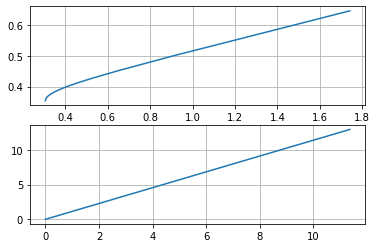

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=False)

ax1.plot(x, y, label = "no free risk asset")
ax2.plot(x2, y2, label = "with free risk asset")


ax1.grid()
ax2.grid()

plt.show()

## Sharpe ratio and tangent portfolio 

The Sharpe ratio of a portfolio is the excess-rate-of-return per unit of risk
$$ S_x = \frac{\mu_x - r}{\sigma_x} $$
$\mu_x = r$ excess rate-of-return : difference between the portfolio's expected return and the return r of the risk-free asset.

Risk ($\sigma_x$) is measured throuhg standard deviation

   - S < 1 : less interesting than risk-free asset when accounting for risk 
   - S $\geq$ 2 : 1% of volatility generates an excess return of $\geq$ 2%

Here is the way that the weight which maximize the Sharpe ratio is calculate : $$w^{MS} = \frac{\Sigma^{-1}(\mu - re)}{e^T\Sigma^{-1}(\mu - re)} $$

##### 1- calculation of portfolio that maximise the Sharpe-Ratio

In [9]:
mu = W_and_mu["mu"]
cov = W_and_mu["Cov"]
def max_SR(mu, cov, r):
    m = len(mu)
    e = np.full((m,1), 1)
    
    max_sr = (np.linalg.inv(cov) @ (mu - r*e)) / (np.transpose(e) @ np.linalg.inv(cov) @ (mu - r*e))
    return max_sr


w_maxsr = max_SR(mu, cov, rf)    

##### 2 - Calculation of expected return and variance of this portfolio

In [10]:
RF = rf
mu_msr = w_maxsr.transpose() @ mu + RF*(1 - w_maxsr.transpose() @ np.full((len(mu),1), 1))
sigma_msr = math.sqrt(w_maxsr.transpose() @ cov @ w_maxsr)

In [11]:
print(float(mu_msr))
print(sigma_msr)

0.36200698883178184
0.3099141043688181


In [12]:
w_maxsr

array([[ 0.65427555],
       [-0.19311446],
       [ 0.53883892]])

In [13]:
print("Sharpe Ratio is equal to = ", (float(mu_msr) - RF)/float(sigma_msr))

Sharpe Ratio is equal to =  1.1358211319510338


##### 3 - Calculation of the slope in order to trace the line between that pass through (0,r) x (sigma_sr, mu_sr)

In [14]:
x2 = [0, float(sigma_msr)]
y2 = [RF, float(mu_msr)]
slope, intercept = np.polyfit(x2,y2,1)
print(slope)

1.1358211319510338


In [15]:
intercept

0.010000000000000023

In [16]:
range = np.arange(0, 1.5, 0.001)
rangey = slope * range + RF

In [17]:
RF

0.01

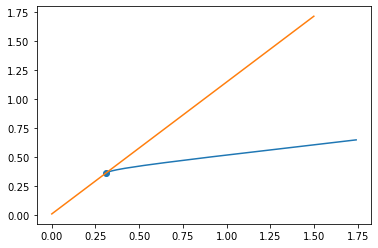

In [18]:
fig, ax = plt.subplots()


ax.plot(x, y)
ax.scatter(sigma_msr, mu_msr)
ax.plot(range, rangey)

plt.show()

### Alternative method to find efficient frontier

In [19]:
assets = ['AAPL', 'NVDA', "AMZN"]
pf_data = pd.DataFrame()
for x in assets:
    pf_data[x] = web.DataReader(x, data_source = 'yahoo', start = '2020-1-1', end = '2022-1-21')['Adj Close']

In [20]:
log_returns = np.log(pf_data/pf_data.shift(1)).dropna()
log_returns.head()

,AAPL,NVDA,AMZN
Date,,,
2020-01-03,-0.009770,-0.016135,-0.012213
2020-01-06,0.007936,0.004185,0.014776
2020-01-07,-0.004714,0.012034,0.002089
2020-01-08,0.015959,0.001874,-0.007839
2020-01-09,0.021018,0.010923,0.004788


In [21]:
Nsim = 10000
n = len(assets)
w = np.zeros((Nsim, n))
portfolio_returns = []
portfolio_volatilities = []
sharpe_ratio = []
rf = 0.01

for i in np.arange(Nsim):
    weights = np.array(np.random.random(n))
    weights = weights/np.sum(weights)
    portfolio_returns.append(np.sum(weights * log_returns.mean()) * 250)
    portfolio_volatilities.append(np.sqrt(np.dot(weights.T,np.dot(log_returns.cov() * 250, weights))))
    sharpe_ratio.append((portfolio_returns[i] - np.array(rf))/portfolio_volatilities[i])
    w[i,:] = weights

portfolios = pd.DataFrame({assets[0] : w[:,0], assets[1] : w[:,1], assets[2] : w[:,2],
                           'Return': portfolio_returns, 'Volatility':portfolio_volatilities, 
                          'sharpe_ratio' : sharpe_ratio})

In [22]:
portfolios.head()

,AAPL,NVDA,AMZN,Return,Volatility,sharpe_ratio
0,0.566352,0.402814,0.030834,0.485897,0.392642,1.212038
1,0.217261,0.559980,0.222759,0.494552,0.402698,1.203263
2,0.042134,0.744044,0.213823,0.547402,0.443104,1.212813
3,0.712830,0.213257,0.073913,0.425278,0.367603,1.129694
4,0.560586,0.040480,0.398935,0.317798,0.324848,0.947512


In [23]:
max(portfolios["sharpe_ratio"])

1.2638438389586248

In [24]:
index = portfolios["sharpe_ratio"].idxmax()
result = pd.DataFrame(portfolios.iloc[index])
result.columns = ['Result']
result

,Result
AAPL,0.213269
NVDA,0.785275
AMZN,0.001456
Return,0.597689
Volatility,0.465001
sharpe_ratio,1.263844


In [25]:
index2 = portfolios["Volatility"].idxmin()
result2 = pd.DataFrame(portfolios.iloc[index2])
result2.columns = ['Result']
result2

,Result
AAPL,0.327042
NVDA,0.002134
AMZN,0.670824
Return,0.257435
Volatility,0.311392
sharpe_ratio,0.794609


In [26]:
vol_maxsr = result.at["Volatility", "Result"]
ret_maxsr = result.at["Return", "Result"]

In [27]:
vol_minvol = result2.at["Volatility", "Result"]
ret_minvol = result2.at["Return", "Result"]

In [28]:
x2 = [0, float(vol_maxsr)]
y2 = [rf, float(ret_maxsr)]
slope, intercept = np.polyfit(x2,y2,1)
print(slope)

1.2638438389586248


In [29]:
range = np.arange(0, 0.5, 0.001)
rangey = slope * range + intercept

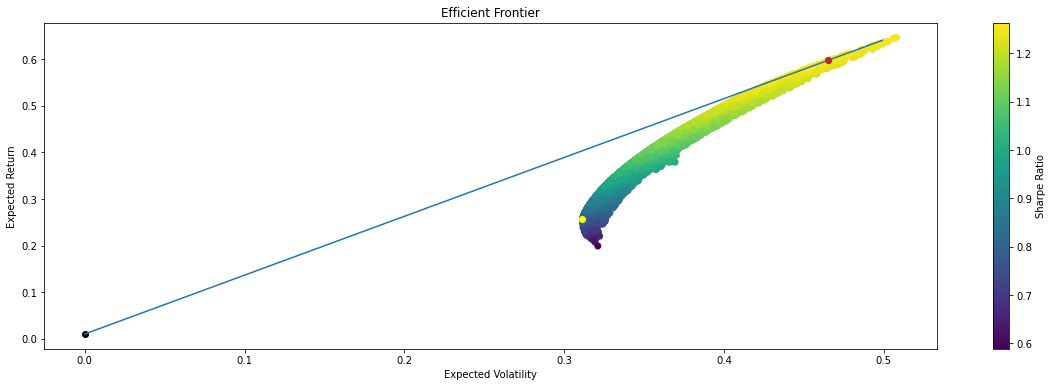

In [30]:
import matplotlib.pyplot as plt
plt.figure(figsize = (20,6))
plt.scatter(x = portfolios["Volatility"], y = portfolios["Return"], c = portfolios["sharpe_ratio"])
plt.xlabel("Expected Volatility")
plt.ylabel("Expected Return")
plt.colorbar(label = 'Sharpe Ratio')
plt.scatter(vol_maxsr, ret_maxsr, c = "red")
plt.scatter(vol_minvol, ret_minvol, c = "yellow")
plt.scatter(0, rf, c = "black")
plt.plot(range, rangey)
plt.title("Efficient Frontier");

### More mathematical way to find the weights that maximise the sharpe-ratio

Here is the optimization program to apply in order to find the weights that maximize the sharpe-ratio.

$$\underset{w}{minimize} \: \: \: w^T \Sigma w$$ 
$$\text{subject to} \: \: \: \mu * w \geq r_{min} $$
$$ w \geq 0 $$
$$ 1^T w = 1 $$

which is equivalent to,

$$\underset{w}{minimize} \: \: \: - SR(w)$$ 
$$ w \geq 0 $$
$$ 1^T w = 1 $$

In [31]:
from scipy.optimize import minimize
#mu = np.array(log_returns.mean())
#cov = np.array(log_returns.cov())

def negSR(w):
    w = np.array(w)
    R = np.sum(w * log_returns.mean()) * 250
    V = np.sqrt(np.dot(w.T,np.dot(log_returns.cov() * 250, w)))
    SR = (R - rf)/V
    return -1*SR

def check(w):
    return np.sum(w) - 1

w0 = [0.25, 0.25, 0.25]
bounds = ((0,1),(0,1),(0,1))
constraints = ({'type':'eq', 'fun':check})
w_opt = minimize(negSR, w0, method = "SLSQP", bounds = bounds, constraints = constraints)

In [32]:
w_opt.x

array([2.30624443e-01, 7.69375557e-01, 3.97902197e-17])

In [33]:
portfolios.iloc[index]

AAPL            0.213269
NVDA            0.785275
AMZN            0.001456
Return          0.597689
Volatility      0.465001
sharpe_ratio    1.263844
Name: 216, dtype: float64

In [34]:
w_opt

     fun: -1.2641856512972396
     jac: array([-0.02161545, -0.0216791 ,  0.16608186])
 message: 'Optimization terminated successfully'
    nfev: 20
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([2.30624443e-01, 7.69375557e-01, 3.97902197e-17])

In [35]:
print("The maximum value of sharpe-ratio is", -w_opt.fun)

The maximum value of sharpe-ratio is 1.2641856512972396


In [36]:
print("The weights that maximize the sharpe ratio are as follow : ",w_opt.x[0].round(3), 
      "for", assets[0]," ",w_opt.x[1].round(3), " for ",  assets[1], " and ", w_opt.x[2].round(3), " for ", assets[2])

The weights that maximize the sharpe ratio are as follow :  0.231 for AAPL   0.769  for  NVDA  and  0.0  for  AMZN


### Optimal portfolio given a risk budget (For you information, not mandatory)
Given a risk budget, this leads to a unique portfolio.

If we want Loss > 25% with less than 1% probability, the portfolio X must obey : 
$$\mu_x + \sigma_x \Phi^{-1}(0.01) \geq -25\% \rightarrow \mu_x \geq -25\% + \sigma_x \Phi^{-1}(0.99) $$ 

In [37]:
from scipy.stats import norm
from scipy.optimize import fsolve

def intersection(sigma_int):
    return (-0.25 + sigma_int * norm.ppf(0.99)) - (slope * sigma_int + RF)

In [38]:
sigma_intersection = fsolve(intersection, 0)
sigma_intersection

array([0.24470495])

In [39]:
mu_intersection = -0.25 + sigma_intersection * norm.ppf(0.99)
mu_intersection

array([0.31926885])

In [40]:
x_cml = np.arange(0,1,0.05)
y_cml = (x_cml * slope) + RF

sigma_i = np.arange(0.01, 1, 0.01)
mu_i = -0.25 + sigma_i * norm.ppf(0.99)

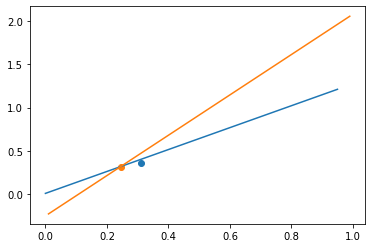

In [41]:
fig, ax = plt.subplots()

ax.plot(x_cml, y_cml)
ax.plot(sigma_i, mu_i)
ax.scatter(sigma_msr, mu_msr)
ax.scatter(sigma_intersection, mu_intersection)


plt.show()

***Figure***: All portfolios on the left of the orange line makes the constraint. Only one is optimal, at
the intersection with the EF (little leverage). Being more tolerant moves the dotted line to the
right.

In [42]:
def opt_ptf_risk_budg(gamma):
    ww = (np.linalg.inv(cov) @ (mu - RF))/gamma
    mu2 = (ww.T @ mu) + RF*(1 - ww.T @ np.full((len(mu), 1), 1))
    return float(mu2) - float(mu_intersection)

In [43]:
opt_gamma = fsolve(opt_ptf_risk_budg, 1)
print("the optimal gamma is ", opt_gamma)

the optimal gamma is  [4.17141802]


In [44]:
print("the optimal portfolio under risk budget is ", (np.linalg.inv(cov) @ (mu - RF))/opt_gamma)

the optimal portfolio under risk budget is  [[ 0.57483814]
 [-0.1696679 ]
 [ 0.47341699]]
